<a href="https://colab.research.google.com/github/moukouel/Notebooks/blob/main/VAEAuto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## VAE Variational Auto Encoder

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import keras
print(tf.__version__)

2.18.0


In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load and normalize the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


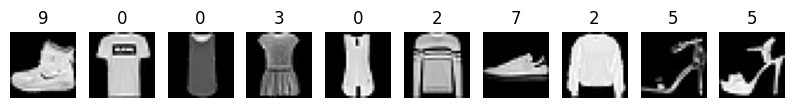

In [ ]:
# Print some sample images
def plot_images(images, labels, num=10):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i])
        plt.axis('off')
    plt.show()
plot_images(x_train, y_train, num=10)

In [ ]:
# Define some hyperparameters
num_classes = 10
batch_size = 64
epochs = 20
learning_rate = 0.001
input_shape = (28, 28, 1)
image_size = x_train.shape[1] * x_train.shape[2]
print("Image size:", image_size)
hidden_dim = 512
latent_dim = 10


Image size: 784


In [ ]:
# Define a VAE model

class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        h_dim = dim[0]
        z_dim = dim[1]
        super(VAE, self).__init__(**kwargs)
        self.fc1 = tf.keras.layers.Dense(h_dim)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(image_size)
        # Activation layer for relu
        self.relu = tf.keras.layers.Activation('relu')
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def encode(self, x):
        h = self.relu(self.fc1(x)) # Using the Activation layer
        return self.fc2(h), self.fc3(h)

    def reparametrize(self, mu, logvar):
        # Wrap tf.exp in a Lambda layer to handle KerasTensors
        std = tf.keras.layers.Lambda(lambda x: tf.exp(0.5 * x))(logvar)
        eps = tf.random.normal(std.shape)
        return mu + eps * std

    def decodeLogits(self, z):
        h = self.relu(self.fc4(z)) # Using the Activation layer
        return self.fc5(h)

    def decode(self, z):
        logits = self.decodeLogits(z)
        return self.sigmoid(logits)

    def call(self, inputs, training=None, mask=None):
        mu, log_var = self.encode(inputs)
        z = self.reparametrize(mu, log_var)
        logits = self.decodeLogits(z)
        return logits, mu, log_var

    # Define the summary function
    def summary(self, line_length=None, positions=None, print_fn=None):

        print("Model summary:")
        print("Encoder: Dense -> ReLU -> Dense (mu) + Dense (log_var)")
        print("Reparameterization: mu + eps * std")
        print("Decoder: Dense -> ReLU -> Dense (logits)")
        print("Output: Sigmoid activation")
        return self

    def build(self, input_shape):
        super(VAE, self).build(input_shape)
        self.summary()



In [ ]:
# Define a custom VAE model using Keras
model = VAE([hidden_dim, latent_dim])
model.build(input_shape=(4, image_size))
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

Model summary:
Encoder: Dense -> ReLU -> Dense (mu) + Dense (log_var)
Reparameterization: mu + eps * std
Decoder: Dense -> ReLU -> Dense (logits)
Output: Sigmoid activation


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(batch_size * 5).batch(batch_size)
num_batches = x_train.shape[0] // batch_size
print("Number of batches:", num_batches)
for epoch in range(epochs):
    for step, x_batch_train in enumerate(dataset):
        x_batch_train = tf.reshape(x_batch_train, [-1, image_size])
        with tf.GradientTape() as tape:
            logits, mu, log_var = model(x_batch_train)
            cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=x_batch_train)
            logpx_z = tf.reduce_sum(cross_entropy) / batch_size
            # KL divergence
            kl = -0.5 * tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl = tf.reduce_mean(kl)
            #Backprop and optimize
            loss = tf.reduce_mean(logpx_z) + kl
        grads = tape.gradient(loss, model.trainable_variables)
        # Apply gradients
        for g in grads:
            g = tf.clip_by_norm(g, 15)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        if step % 900 == 0:
            print("Epoch:[{}/{}], Step: [{}/{}], Reconstruction Loss: {:.4f}, KL Div: {:.4f}".format(epoch + 1, epochs, step + 1, num_batches, float(loss)/len(x_batch_train), float(kl)/len(x_batch_train)))
# Save the model
model.save_weights('vae.weights.h5')


Number of batches: 937
Epoch:[1/20], Step: [1/937], Reconstruction Loss: 8.5498, KL Div: 0.0234
Epoch:[1/20], Step: [901/937], Reconstruction Loss: 3.8437, KL Div: 0.2256
Epoch:[2/20], Step: [1/937], Reconstruction Loss: 4.2113, KL Div: 0.2393
Epoch:[2/20], Step: [901/937], Reconstruction Loss: 3.8952, KL Div: 0.2315
Epoch:[3/20], Step: [1/937], Reconstruction Loss: 3.9761, KL Div: 0.2272
Epoch:[3/20], Step: [901/937], Reconstruction Loss: 3.6057, KL Div: 0.2277
Epoch:[4/20], Step: [1/937], Reconstruction Loss: 3.8876, KL Div: 0.2294
Epoch:[4/20], Step: [901/937], Reconstruction Loss: 3.9345, KL Div: 0.2338
Epoch:[5/20], Step: [1/937], Reconstruction Loss: 3.8624, KL Div: 0.2327
Epoch:[5/20], Step: [901/937], Reconstruction Loss: 3.7876, KL Div: 0.2566
Epoch:[6/20], Step: [1/937], Reconstruction Loss: 3.6867, KL Div: 0.2382
Epoch:[6/20], Step: [901/937], Reconstruction Loss: 3.7169, KL Div: 0.2344
Epoch:[7/20], Step: [1/937], Reconstruction Loss: 3.9486, KL Div: 0.2352
Epoch:[7/20], St

Reconstructed images shape: (64, 28, 28)


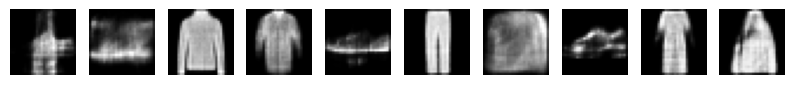

In [11]:
z = tf.random.normal((batch_size, latent_dim))
reconstructed_images = model.decode(z)
reconstructed_images = tf.reshape(reconstructed_images, [-1, 28, 28]).numpy() * 255
reconstructed_images = reconstructed_images.astype(np.uint8)
print("Reconstructed images shape:", reconstructed_images.shape)
# Plot reconstructed images
def plot_reconstructed_images(images, num=10):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')

    plt.show()
plot_reconstructed_images(reconstructed_images, num=10)

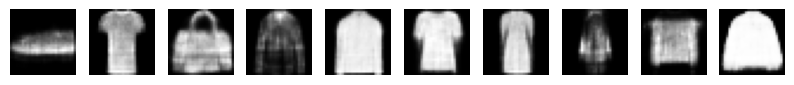

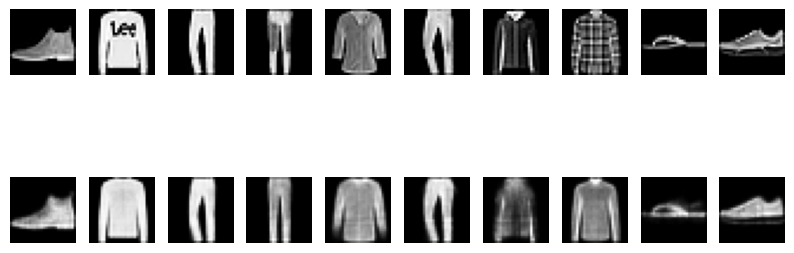

In [12]:

# Generate new samples
def generate_samples(model, num_samples=10):
    z = tf.random.normal((num_samples, latent_dim))
    logits = model.decodeLogits(z)
    samples = tf.nn.sigmoid(logits)
    return samples
def plot_generated_samples(samples, num=10):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(samples[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()
generated_samples = generate_samples(model, num_samples=10)
plot_generated_samples(generated_samples, num=10)
# Reconstruct some test images
def reconstruct_images(model, images):
    images = tf.reshape(images, [-1, image_size])
    logits, _, _ = model(images)
    reconstructed_images = tf.nn.sigmoid(logits)
    return reconstructed_images
def plot_reconstructed_images(original, reconstructed, num=10):
    plt.figure(figsize=(10, 4))
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        plt.subplot(2, num, i + 1 + num)
        plt.imshow(reconstructed[i].numpy().reshape(28, 28), cmap='gray')
        plt.axis('off')

    plt.show()
test_images = x_test[:10]
reconstructed_images = reconstruct_images(model, test_images)
plot_reconstructed_images(test_images, reconstructed_images, num=10)


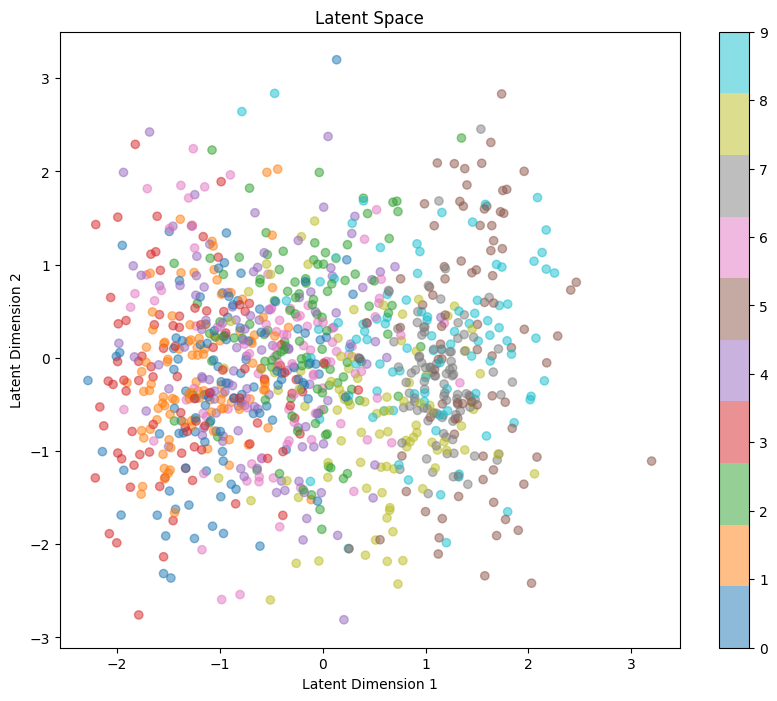

In [13]:
# Visualize the latent space
def plot_latent_space(model, images, labels):
    images = tf.reshape(images, [-1, image_size])
    mu, _ = model.encode(images)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu[:, 0], mu[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Latent Space')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()
latent_space_images = x_test[:1000]
latent_space_labels = y_test[:1000]
plot_latent_space(model, latent_space_images, latent_space_labels)

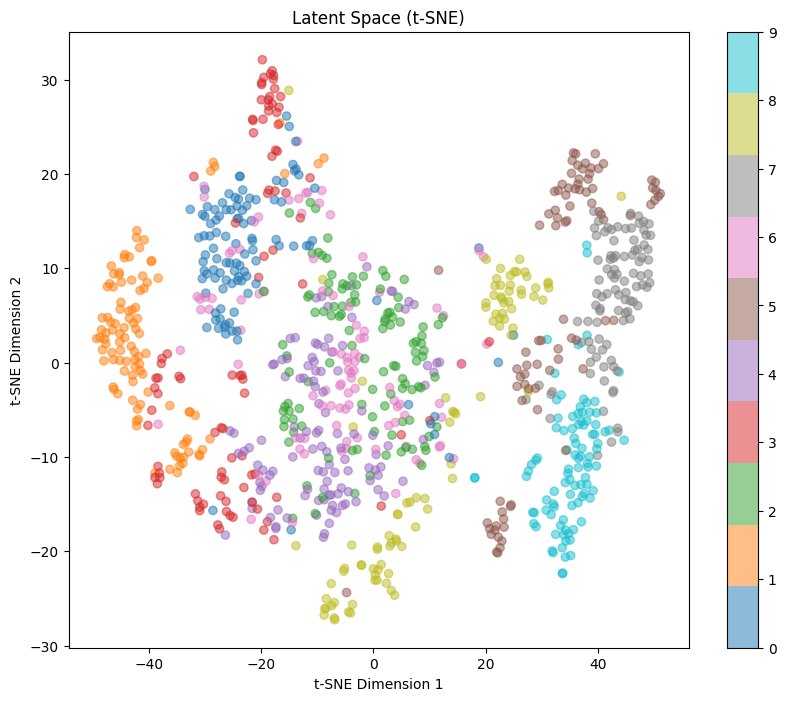

In [14]:
# Visualize the latent space with t-SNE
from sklearn.manifold import TSNE
def plot_latent_space_tsne(model, images, labels):
    images = tf.reshape(images, [-1, image_size])
    mu, _ = model.encode(images)
    tsne = TSNE(n_components=2, random_state=0)
    mu_tsne = tsne.fit_transform(mu)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Latent Space (t-SNE)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
latent_space_images = x_test[:1000]
latent_space_labels = y_test[:1000]
plot_latent_space_tsne(model, latent_space_images, latent_space_labels)

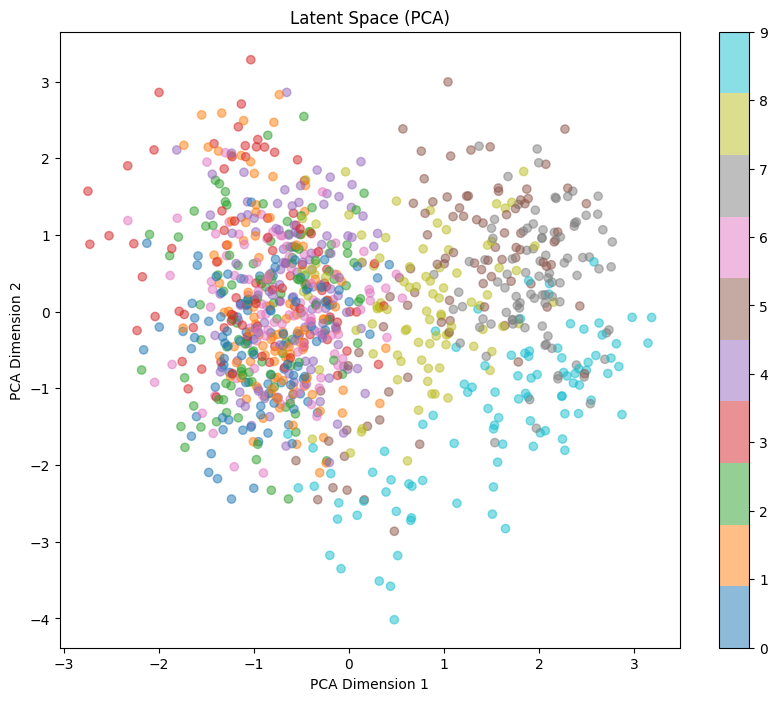

In [15]:
# Visualize the latent space with PCA
from sklearn.decomposition import PCA
def plot_latent_space_pca(model, images, labels):
    images = tf.reshape(images, [-1, image_size])
    mu, _ = model.encode(images)
    pca = PCA(n_components=2)
    mu_pca = pca.fit_transform(mu)
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu_pca[:, 0], mu_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter)
    plt.title('Latent Space (PCA)')
    plt.xlabel('PCA Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()
latent_space_images = x_test[:1000]
latent_space_labels = y_test[:1000]
plot_latent_space_pca(model, latent_space_images, latent_space_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


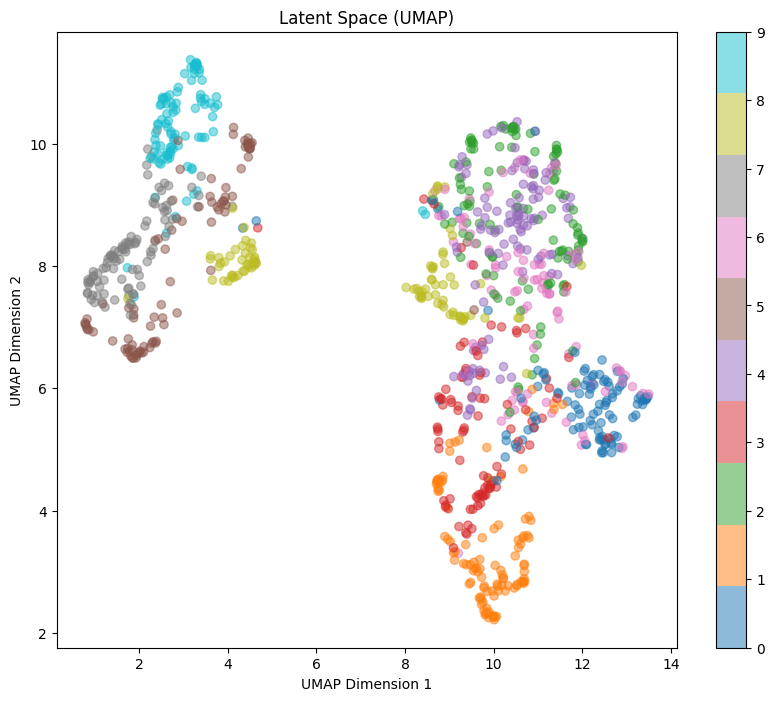

In [16]:
# Visualize the latent space with UMAP
try:
    import umap
    def plot_latent_space_umap(model, images, labels):
        images = tf.reshape(images, [-1, image_size])
        mu, _ = model.encode(images)
        reducer = umap.UMAP(n_components=2, random_state=0)
        mu_umap = reducer.fit_transform(mu)
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(mu_umap[:, 0], mu_umap[:, 1], c=labels, cmap='tab10', alpha=0.5)
        plt.colorbar(scatter)
        plt.title('Latent Space (UMAP)')
        plt.xlabel('UMAP Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.show()
    latent_space_images = x_test[:1000]
    latent_space_labels = y_test[:1000]
    plot_latent_space_umap(model, latent_space_images, latent_space_labels)
except ImportError:
    print("UMAP is not installed. Please install it to visualize the latent space with UMAP.")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


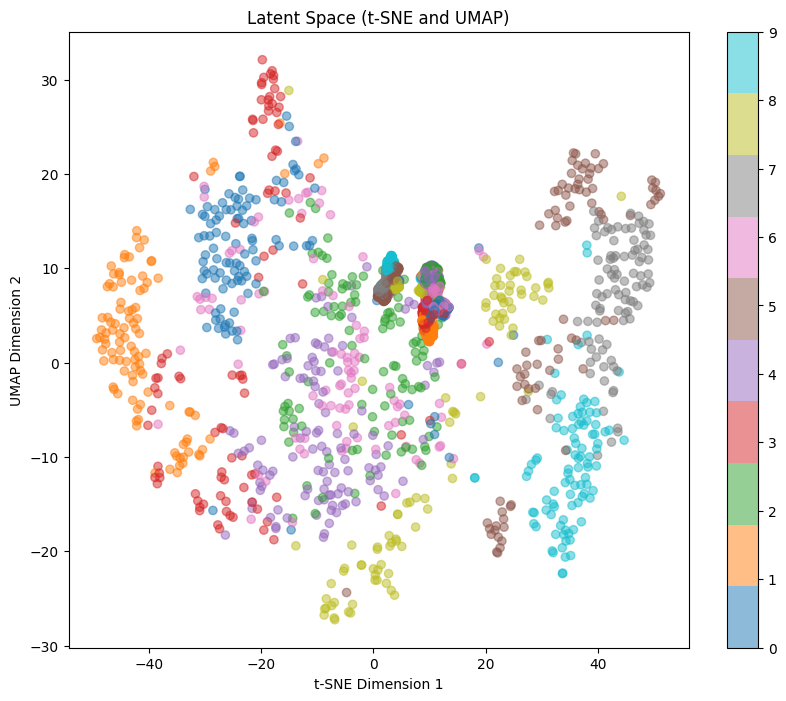

In [17]:
# Visualize the latent space with t-SNE and UMAP
def plot_latent_space_tsne_umap(model, images, labels):
    images = tf.reshape(images, [-1, image_size])
    mu, _ = model.encode(images)
    tsne = TSNE(n_components=2, random_state=0)
    mu_tsne = tsne.fit_transform(mu)
    try:
        import umap
        reducer = umap.UMAP(n_components=2, random_state=0)
        mu_umap = reducer.fit_transform(mu)
        plt.figure(figsize=(10, 8))
        scatter1 = plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
        scatter2 = plt.scatter(mu_umap[:, 0], mu_umap[:, 1], c=labels, cmap='tab10', alpha=0.5)
        plt.colorbar(scatter1)
        plt.title('Latent Space (t-SNE and UMAP)')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('UMAP Dimension 2')
        plt.show()
    except ImportError:
        print("UMAP is not installed. Please install it to visualize the latent space with t-SNE and UMAP.")
latent_space_images = x_test[:1000]
latent_space_labels = y_test[:1000]
plot_latent_space_tsne_umap(model, latent_space_images, latent_space_labels)

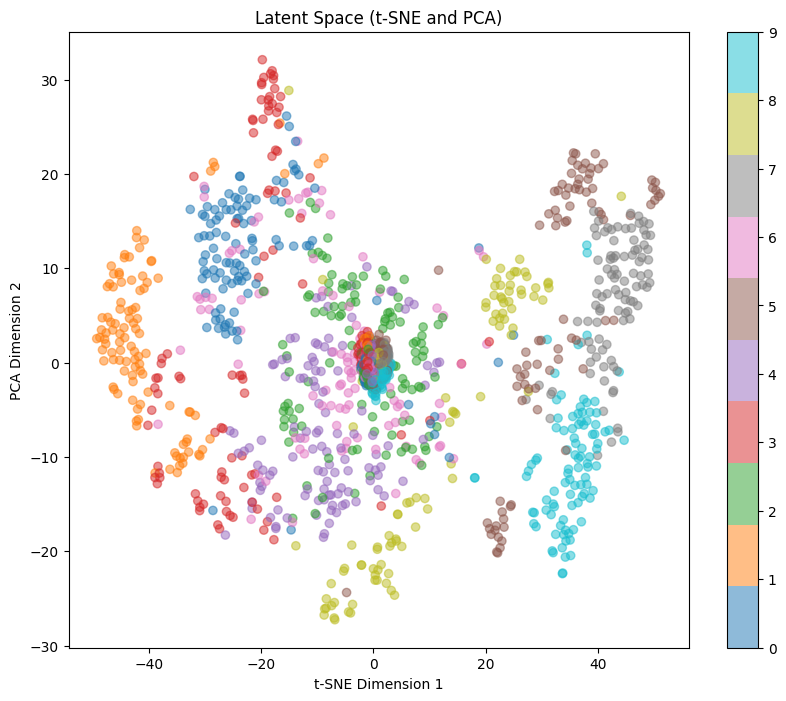

In [18]:
# Visualize the latent space with t-SNE and PCA
def plot_latent_space_tsne_pca(model, images, labels):
    images = tf.reshape(images, [-1, image_size])
    mu, _ = model.encode(images)
    tsne = TSNE(n_components=2, random_state=0)
    mu_tsne = tsne.fit_transform(mu)
    pca = PCA(n_components=2)
    mu_pca = pca.fit_transform(mu)
    plt.figure(figsize=(10, 8))
    scatter1 = plt.scatter(mu_tsne[:, 0], mu_tsne[:, 1], c=labels, cmap='tab10', alpha=0.5)
    scatter2 = plt.scatter(mu_pca[:, 0], mu_pca[:, 1], c=labels, cmap='tab10', alpha=0.5)
    plt.colorbar(scatter1)
    plt.title('Latent Space (t-SNE and PCA)')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('PCA Dimension 2')
    plt.show()
latent_space_images = x_test[:1000]
latent_space_labels = y_test[:1000]
plot_latent_space_tsne_pca(model, latent_space_images, latent_space_labels)
